**MAKING PICTURES

In [91]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *


        

#copyed from common_utils to change here
def optimize(optimizer_type, parameters, closure, LR, num_iter, inpaintinglog = None):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam' #no change
        parameters: list of Tensors to optimize over ## 
        closure: function, that returns loss variable #no change
        LR: learning rate #no change
        num_iter: number of iterations  #no change
    """
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        for j in range(num_iter):
            optimizer.zero_grad()
#             closure()
            closure(j, inpaintinglog)
            optimizer.step()


    else:
        assert False


def inpainting(container, cuda = False, iterations = 100):
    
    seq_np = container.seq_np
    mask_np = container.mask_np

    if cuda: 
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark =True
        dtype = torch.cuda.FloatTensor
    else:
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        dtype = torch.FloatTensor

    PLOT = False
    imsize = -1
    dim_div_by = 64

    NET_TYPE = 'skip_depth6'
    pad = 'reflection' # 'zero'
    OPT_OVER = 'net'
    OPTIMIZER = 'adam'

    INPUT = 'noise'
    input_depth = 32
    LR = 0.01 
    num_iter = iterations
    param_noise = False
    show_every = 5
    figsize = 5 #????
    reg_noise_std = 0.03

    net = skip(input_depth, seq_np.shape[0], #change skip function in models/skip.py
               num_channels_down = [128] * 3,
               num_channels_up =   [128] * 3,
               num_channels_skip =    [128] * 3,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    

    net = net.type(dtype) 
    net_input = get_noise(input_depth, INPUT, seq_np.shape[1]).type(dtype) #tensor 

    
    s  = sum(np.prod(list(p.size())) for p in net.parameters())
    print ('Number of params: %d' % s)
    
    inpaintinglog = Inpaintinglog()
    inpaintinglog.add_net_parameters([NET_TYPE, pad, OPT_OVER, OPTIMIZER, INPUT, 
                                 input_depth, LR, reg_noise_std, num_iter, cuda, s])


    # Loss
    mse = torch.nn.MSELoss().type(dtype)

    # img_var = np_to_torch(img_np).type(dtype)
    # mask_var = np_to_torch(img_mask_np).type(dtype)

    img_var = np_to_torch(seq_np).type(dtype)
    mask_var = np_to_torch(mask_np).type(dtype)
    
    
    def closure(i = None, inpaintinglog = None):
        
#         if i == None: use global i and i+=1
#         global i
    #     if param_noise:
    #         for n in [x for x in net.parameters() if len(x.size()) == 4]:
    #             n = n + n.detach().clone().normal_() * n.std() / 50

        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        out = net(net_input)
  
        total_loss = mse(out * mask_var, img_var * mask_var)
        total_loss.backward()
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        if inpaintinglog != None:
            inpaintinglog.loss.append(total_loss)
            if i % inpaintinglog.out_nps_every == 0:
                inpaintinglog.out_nps.append(out)

#         i += 1

        return total_loss


    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    p = get_params(OPT_OVER, net, net_input) # list of tensors to optimize over !! in optimize
    optimize(OPTIMIZER, p, closure, LR, num_iter, inpaintinglog) # optimize is in utils/common.utils
    out_np = torch_to_np(net(net_input))

    
    return out_np, inpaintinglog

In [92]:
from PIL import Image
import PIL
import numpy as np
import IPython.display
import random 

from Bio import SeqIO
import math
from collections import Counter
import datetime
import time
import matplotlib.pyplot as plt

fasta_file = "data/myco_genome.fasta"
local_genome = "/Users/pochtalionizm/Projects/neuro/data/GCF_000195955.2_ASM19595v2_genomic.gbff"
remote_genome = "data/myco_genome.gbff"

In [97]:
class Inpaintinglog():
    def __init__(self):
        self.datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        self.loss = []
        self.runtime = None
        self.out_nps = []
        self.out_nps_every = 10000
        self.net_parameters = None
        self.description = None
    
    def plot_loss(self, plot = False, length= -1, mask = -1):
        fig = plt.plot(self.loss)
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.title("{}\n{}\n{}_{}".format(self.datetime, self.description, str(length), str(mask)))
        if plot:
            plt.savefig("data/loss_{}.png".format(self.datetime))
        plt.show()
        
    def add_net_parameters(self, p):
        self.net_parameters = p 
        #[NET_TYPE, pad, OPT_OVER, OPTIMIZER, INPUT, input_depth, LR, reg_noise_std, num_iter, cuda, num_parameters]
        self.description = "_".join([str(x) for x in p])
        
    


class Container:
    def __init__(self):
        self.record = None #Seq??
        self.length = None #int
        self.seq = None #np.array of chars
        self.seq_np = None #np.array of [1, 0, 0, 0]
        self.out_seq = None #np.array of chars
        self.out_array = None #np.array of [1, 0, 0, 0]
        
        
        self.bases_dict     = {"A": 0, "T": 1, "C": 2, "G": 3}
        self.bases_list = ["A", "T", "C", "G"]
        self.bases_np        = {"A": np.array([1, 0, 0, 0], dtype = np.float32),
                             "T": np.array([0, 1, 0, 0], dtype = np.float32),
                             "C": np.array([0, 0, 1, 0], dtype = np.float32),
                             "G": np.array([0, 0, 0, 1], dtype = np.float32)
                            }
        self.freqs = None # dict {'A':0.34, ...}
        self.counter = {}
        self.inpaintinglog = None
        print("container created")
        
        
    def read_seq(self, genome_file = remote_genome, genome_file_type = "genbank"):
        iterator = SeqIO.parse(genome_file, genome_file_type)
        self.record = next(iterator)
        self.seq = np.asarray(self.record.seq) 
        
        print("read seq from file {}, length = {}".format(genome_file, len(self.record.seq)))
    
    def generate_seq(self, length = None):
        if length == None:
            length = len(self.record.seq)
        seq_np = np.zeros((4, length), dtype = np.float32)
        for index in range(length):
            base = self.seq[index]
            channel = self.bases_dict[base]
            seq_np[channel][index] = 1
            
            
        self.length = length
        self.seq_np = seq_np
        
        print("generated seq for analysis, length = {}".format(self.length))
        
    def generate_mask(self, seed=False):
        length = self.length
        length_mask = math.ceil(self.length * 0.1)
        
        if seed:
            random.seed(7)
        mask_np = np.zeros((4, length), dtype=np.float32)
        mask = np.zeros(length)
        
        mask_np.fill(1)
        for n in range(length_mask):
            spot = 1
            index = random.randint(0, length-spot)
            for i in range(index, index+spot):
                mask_np[:, i] = [0,0,0,0]
                mask[i] = 1
                
        self.mask_np = mask_np
        self.length_mask = int(sum(mask)) # true mask length!!
        self.mask = mask

        print("generated mask with {} spots of {} bp, seed {}".format(self.length_mask, spot, seed))
        
    def inpaint(self, out_np = None, inpaintinglog = None):
        if out_np is None:
            self.out_np, self.inpaintinglog = inpainting(self)
        else:
            self.out_np = out_np
            self.inpaintinglog = inpaintinglog
            print("assigned inpainted array and log")
            
    
    def _get_freqs(self):
        counter = Counter(self.seq[0:self.length])
        self.freqs = {letter : value / self.length for (letter, value) in counter.items()}
    
    def _baseline(self): #count mistakes under mask if using random predictor with frequences
        counter = 0
        for i in range(self.length):
            if self.mask[i] == 1: #if its under mask
                w = [self.freqs[x] for x in self.bases_list]
                letter = random.choices(self.bases_list, weights=w)[0]
                if letter != self.seq[i]:
                        counter +=1
        return counter
    
    
    def baseline(self):
        self._get_freqs()
        baselines = []
        for i in range(100):
            baselines.append(self._baseline())
        mean = np.mean(baselines)
        sd = np.std(baselines)
        self.counter["baseline_mean"] = mean
        self.counter["baseline_sd"] = sd
        print("got baseline")

    def generate_out(self): 
        
        out_seq = np.zeros(self.length, dtype= "U8")
        for i in range(self.length):
            channel = np.argmax(self.out_np[:, i])
            out_seq[i] = self.bases_list[channel] 
            
        out_array = np.zeros((4,self.length)) #array analog to seq_np
        for i in range(self.length):
            n = np.argmax(self.out_np[:, i])
            out_array[n, i] = 1
            
        self.out_seq = out_seq
        self.out_array = out_array
        
        self.coding = np.zeros(self.length)
        for f in self.record.features:
            if f.type == "CDS":
                start = f.location.start
                end = f.location.end
                self.coding[start: end + 1] = 1 
                
        
        
        diff = np.zeros(self.length)
        for i in range(self.length):
            if not np.array_equal(self.out_array[:, i], self.seq_np[:, i]):
                diff[i] = 1
        self.diff = diff
        
        print("generated out arrays")
        
    def generate_counter(self):
        c = self.counter
        c["all_mist"] = sum(self.diff)
        c["mask_mist"] = sum(self.diff * self.mask)
        c["free_mist"] = sum(self.diff) - sum(self.diff * self.mask)
        
        if c["all_mist"] != c["mask_mist"] + c["free_mist"]:
            print("error in counter")
        
        c["coding_mask"] = sum(self.mask * self.coding)
        c["noncoding_mask"] = sum(self.mask) - sum(self.mask * self.coding) 
        
        if c["coding_mask"]+ c["noncoding_mask"] != self.length_mask:
            print("error in counter")
        
        c["coding_mask_mist"] = sum(self.diff * self.mask * self.coding)
        c["noncoding_mask_mist"] = sum(self.diff * self.mask) - sum(self.diff * self.mask * self.coding)
        
        if c["coding_mask_mist"]+c["noncoding_mask_mist"] != c["mask_mist"]:
            print("error in counter")
        
        c["mask_part"] = c["mask_mist"] / self.length_mask
        c["coding_part"] = c["coding_mask_mist"] / c["coding_mask"]
        c["noncoding_part"] = c["noncoding_mask_mist"] / c["noncoding_mask"]
        c["baseline_part"] = c["baseline_mean"] / self.length_mask
        c["baseline_part_sd"] = c["baseline_sd"] / self.length_mask
        
        c["free_part"] = c["free_mist"] / (self.length - self.length_mask)
        
        
        
        print("generated counter")
    
    
    def print_results(self):
        interpretation = ("mask\tcoding\tnoncod\tfreqs\t+-\tfree")
        c = self.counter
        results = "{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}\t{:.3}".format(c["mask_part"],  c["coding_part"], c["noncoding_part"], 
                                                             c["baseline_part"], c["baseline_part_sd"], c["free_part"])
        print(interpretation)
        print(results)

#         file = open("data/nnet_results.txt", "+a")
#         file.write("#{}\tlength\tmask\t{}\n".format(interpretation, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
#         file.write("{}\t{}\t{}\t{}\n".format(results, self.length, self.length_mask, description))
#         file.close()
        
        nn = self.inpaintinglog
        
        file = open("data/nnet_log.txt", "+a")
        file.write("#{}\n".format(nn.datetime, nn.description))
        file.write("{}\tlength\tmask\n".format(interpretation))
        file.write("{}\t{}\t{}\n".format(results, self.length, self.length_mask))
        file.write("{}\n".format(self.counter))
        file.close()
    
#         self.title = "{}\n{}\t{}\n{}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), self.length, self.length_mask, description)

In [98]:
container = Container()
container.read_seq(remote_genome)

container created
read seq from file data/myco_genome.gbff, length = 4411532


In [99]:
container.generate_seq(length = 10000)
container.generate_mask(seed=True)

generated seq for analysis, length = 10000
generated mask with 958 spots of 1 bp, seed True


In [100]:
start_time = time.time()

i = 0
out_np, inpaintinglog = inpainting(container, cuda=True, iterations = 10)

elapsed_time = time.time() - start_time

print("\ntime: {:.3}s".format(elapsed_time))

Number of params: 646788
Starting optimization with ADAM
Iteration 00009    Loss 0.169788 
time: 0.2s


In [101]:
container.inpaint(out_np, inpaintinglog)
container.baseline()
container.generate_out()
container.generate_counter()


assigned inpainted array and log
got baseline
generated out arrays
generated counter


In [102]:
container.print_results()

mask	coding	noncod	freqs	+-	free
0.704	0.703	0.711	0.735	0.014	0.604


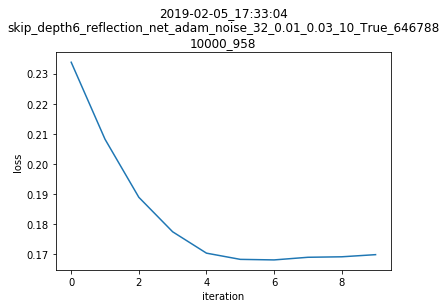

In [103]:
container.inpaintinglog.plot_loss(False, container.length, container.length_mask)

In [84]:
print(container.inpaintinglog.loss)

[]


In [11]:
# from Bio import SeqIO
# iterator = SeqIO.parse(remote_genome, "genbank")
# record = next(iterator)
    
# # print(record.annotations.keys())
# # print(record.features[0].type)
# # print(dir(record.features[5].location))
# # print(record.features[5].location.start)
# # for f in record.features:
# #     print(f.type)
# #     print(f.location.start)

# print(len(record.seq))


4411532


In [12]:
# x = np.zeros(10)
# x[1:3] = 1
# print(x)

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]


container created


KeyError: 'baseline_mean'

In [13]:
1005 % 1000

5

IndexError: list assignment index out of range